<a href="https://colab.research.google.com/github/Samihassan686/CV-SVM/blob/main/Final_Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Computer Vision Project**


We selected a multiclass animal image dataset that consists of following classes:

1.   Dogs
2.   Cats
3.   Pandas

Link to dataset: https://www.kaggle.com/datasets/ashishsaxena2209/animal-image-datasetdog-cat-and-panda


Group Members:


*   Hassan Sami
*   Shaheer Khan



### **Importing Necessary Libraries/Packages**

In [ ]:
import os
import cv2
import numpy as np
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from sklearn.decomposition import PCA, FastICA
from skimage.feature import local_binary_pattern
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# dataset path
dataset_path = '/content/drive/MyDrive/Datasets/Animal-Classification/animals/animals'

## **Data Augmentation and Preprocessing**

The datagen.flow_from_directory function loads images from a specified directory, resizes them to 150x150 pixels, applies defined augmentation parameters, and organizes them into batches. This setup is crucial for effective multi-class classification training and ensures that preprocessing is uniformly applied to maintain consistency across the dataset.


**Augmentations Applied:**

* **Rotation**: Randomly rotates images up to 40 degrees to introduce variability and help the model generalize better.
* **Width Shift**: Horizontally shifts images by up to 20% of their width to simulate off-center positioning of subjects.
* **Height Shift**: Vertically shifts images by up to 20% of their height, introducing variations in the vertical placement of subjects.
* **Shear**: Applies a shear transformation up to 20%, skewing images to simulate a change in perspective.
* **Zoom**: Randomly zooms into images by up to 20%, helping the model learn from different scales.
* **Horizontal Flip**: Flips images horizontally, creating mirror images, useful for learning symmetrical properties.
* **Fill Mode**: Uses the 'nearest' strategy for filling in newly created pixels during transformations like rotation or shifts.

**Preprocessing Applied Using OpenCV:**

* **Grayscale Conversion**: Directly loads images in grayscale, simplifying the input data and reducing computational complexity.
* **Histogram Equalization**: Improves the contrast of the images, making features more distinct and easier for the model to learn.
* **Gaussian Blur**: Applies a Gaussian blur with a 5x5 kernel to denoise the images, smoothing out noise and reducing overfitting risks.
* **Normalization**: Scales pixel values to a range of 0 to 1. This step is handled by the ImageDataGenerator itself as part of the preprocessing function, ensuring numerical stability and faster convergence during training.

In [ ]:
# Define the augmentation parameters with a custom preprocessing function
augmentation_parameters = {
    'rotation_range': 40,  # degrees
    'width_shift_range': 0.2,  # fraction of total width
    'height_shift_range': 0.2,  # fraction of total height
    'shear_range': 0.2,  # shear intensity
    'zoom_range': 0.2,  # zoom range
    'horizontal_flip': True,  # enable horizontal flipping
    'fill_mode': 'nearest',  # fill strategy for newly created pixels
    'preprocessing_function': None  # Placeholder for custom preprocessing
}

def custom_preprocessing(img):
    # Assume img input is (150, 150, 1) from 'grayscale' color_mode in ImageDataGenerator
    if img.shape[-1] == 1:
        img = img.reshape((150, 150))  # Simplify to (150, 150) for CV operations

    # Ensure the image is in 8-bit, single-channel format
    img = img.astype('uint8')

    # Apply histogram equalization to improve contrast
    img = cv2.equalizeHist(img)

    # Apply Gaussian blur as a denoising technique
    img = cv2.GaussianBlur(img, (5, 5), 0)

    # Expand dimensions to add the channel dimension back
    img = np.expand_dims(img, axis=-1)

    return img

# Update the ImageDataGenerator with the custom preprocessing function
augmentation_parameters['preprocessing_function'] = custom_preprocessing

# Initialize the ImageDataGenerator with the specified augmentation and preprocessing parameters
datagen = ImageDataGenerator(**augmentation_parameters)

# Create a generator that loads, augments, and preprocesses images
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(150, 150),  # Resize images to 150x150 pixels
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale'  # Ensure images are loaded in grayscale to match preprocessing function
)

Found 3000 images belonging to 3 classes.


### **Dataset Sample After Augmentation and Preprocessing**

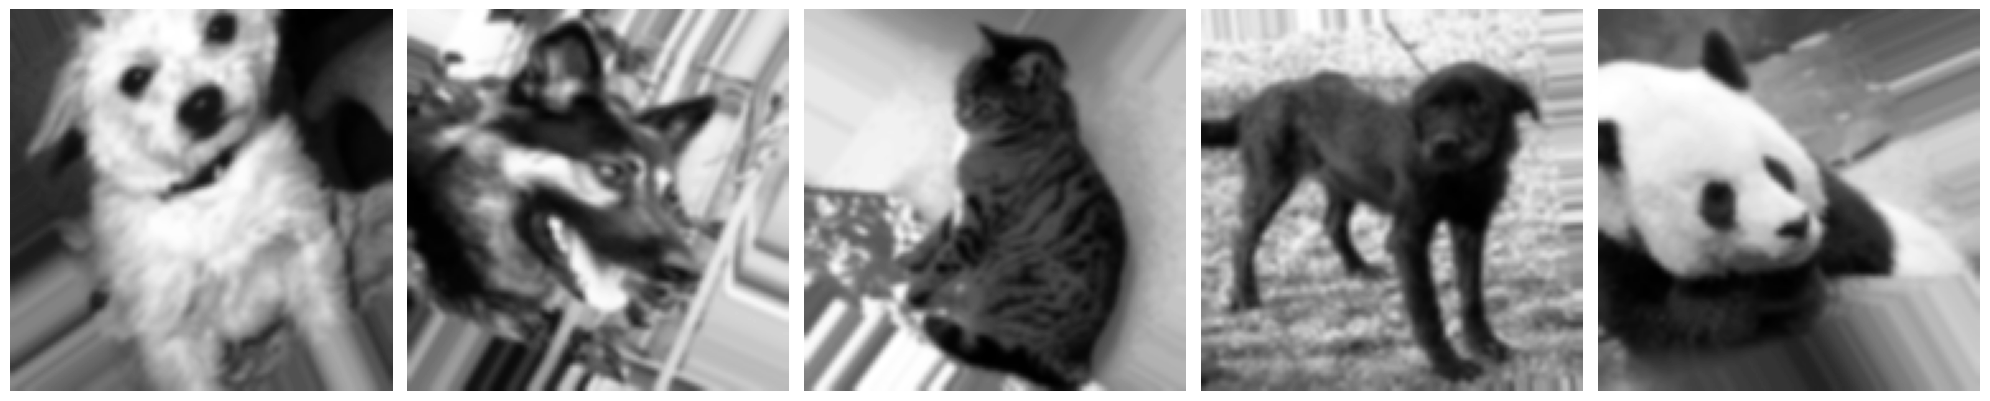

In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        # Ensure image is in correct format for displaying
        if img.ndim == 3 and img.shape[-1] == 1:
            img = img.squeeze()  # Remove singleton channel dimension for display
        ax.imshow(img, cmap='gray')  # Use gray colormap for grayscale images
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Fetch and display images from the train_generator to see the effects of augmentation and preprocessing
sample_images, _ = next(train_generator)
plotImages(sample_images[:5])

### **Dataset Balance**

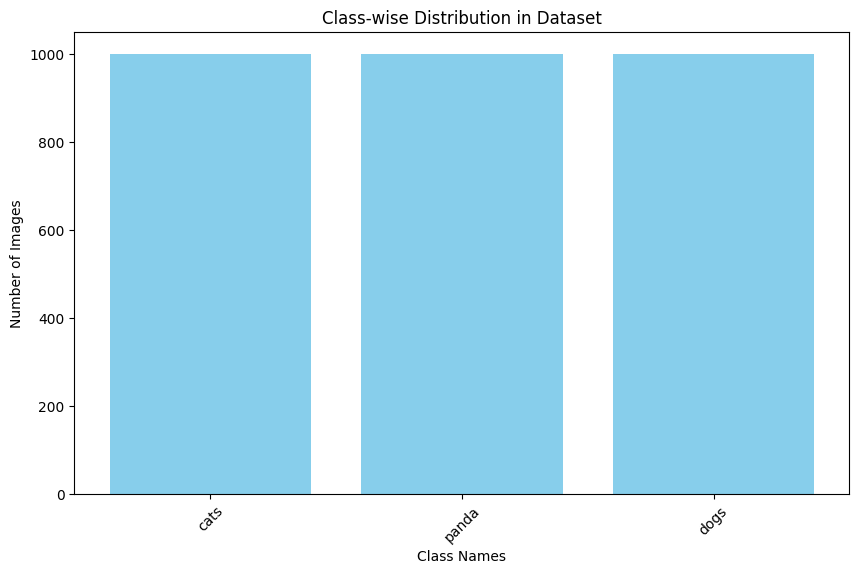

In [ ]:
class_counts = {}
for class_dir in os.listdir(dataset_path):
    class_dir_path = os.path.join(dataset_path, class_dir)
    if os.path.isdir(class_dir_path):  # Ensure it's a directory
        class_counts[class_dir] = len(os.listdir(class_dir_path))  # Count files in each directory

class_names = list(class_counts.keys())
image_counts = list(class_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(class_names, image_counts, color='skyblue')
plt.xlabel('Class Names')
plt.ylabel('Number of Images')
plt.title('Class-wise Distribution in Dataset')
plt.xticks(rotation=45)  # Rotate class names for better visibility if needed
plt.show()

## **Feature Extraction**

Here we will carry out two types of feature extraction:


*   Low level feature extraction
*   High level feature extraction


### **Low Level Feature Extraction**


*   HOG (Histogram Oriented Gradients)
*   LBP (Local Binary Patterns)

*   **HOG and LBP Feature Extraction**: Functions are defined to extract HOG and LBP features, which are then applied to each image in each batch processed by the generator.

*   **Loop Through Generator**: The loop processes a predefined number of batches from the generator. Adjust the number of batches to process based on your dataset size and memory constraints.

*   **Normalization in LBP**: Normalization of the LBP histogram is crucial to ensure feature scale uniformity, which is important for many machine learning models.

In [ ]:
# Function to extract Histogram of Oriented Gradients (HOG) features
def extract_hog_features(image):
    # Convert to 8-bit if not already (this should ideally be handled in preprocessing)
    if image.dtype != np.uint8:
        image = (image * 255).astype('uint8')

    winSize = (20, 20)
    blockSize = (10, 10)
    blockStride = (5, 5)
    cellSize = (10, 10)
    nbins = 9
    hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins)
    hog_features = hog.compute(image)
    return hog_features.flatten()

# Function to extract Local Binary Patterns (LBP) features
def extract_lbp_features(image, radius=1, points=8):
    lbp = local_binary_pattern(image, points, radius, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(),
                             bins=np.arange(0, points + 3),
                             range=(0, points + 2))
    # Normalize the histogram
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist

# Arrays to store features and labels
hog_features_list = []
lbp_features_list = []
labels_list = []

# Loop through all batches in the generator
for i in range(len(train_generator)):
    img_batch, label_batch = next(train_generator)  # Get a batch of images and labels
    for img, label in zip(img_batch, label_batch):
        # Flatten image from 3D to 2D
        img = img[:, :, 0]  # Assuming grayscale and removing the channel dimension

        # Convert to 8-bit if not already
        if img.dtype != np.uint8:
            img = (img * 255).astype('uint8')

        # Extract features
        hog_features = extract_hog_features(img)
        lbp_features = extract_lbp_features(img)

        # Append features and label
        hog_features_list.append(hog_features)
        lbp_features_list.append(lbp_features)
        labels_list.append(label)

    # Optional: Break after first few batches to speed up testing
    if i == 10:  # Adjust this value based on how many batches you want to process
        break

# Convert lists to numpy arrays for use in machine learning
hog_features_array = np.array(hog_features_list)
lbp_features_array = np.array(lbp_features_list)
labels_array = np.array(labels_list)

print("Feature extraction complete.")

Feature extraction complete.


### **High Level Feature Extraction**

**Model Initialization**:

*   VGG16 Model: Load the VGG16 model pre-trained on ImageNet, excluding the top fully connected layers (include_top=False), to use it for feature extraction.
*   Model Configuration: Create a new model that outputs the feature maps from the last convolutional block of VGG16.

**Feature Extraction Function**:

*   Preprocessing: Convert the image to an array, expand dimensions to match the input shape expected by the model, and apply the necessary preprocessing steps.
*   Feature Extraction: Pass the preprocessed image through the VGG16 model to extract high-level features.

**Processing Images**:

*   Loop Through Generator: Iterate over the batches of images provided by the train_generator.
*   Extract Features: For each image in the batch, extract features using the pre-trained CNN and store them in a list along with the corresponding labels.

**Convert to Numpy Arrays**: After processing the desired number of batches, convert the lists of features and labels into numpy arrays for use in training machine learning models.

In [ ]:
# Load the pre-trained VGG16 model + higher level layers
base_model = VGG16(weights='imagenet', include_top=False)

# Model for feature extraction
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-1].output)

# Function to preprocess and extract features using VGG16
def extract_cnn_features(image):
    # Ensure image is in the correct shape and type
    image = img_to_array(image)
    image = np.repeat(image, 3, axis=-1)  # Convert single-channel to three-channel
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    features = model.predict(image)
    return features.flatten()

# Arrays to store features and labels
cnn_features_list = []
labels_list = []

# Loop through all batches in the generator
for i in range(len(train_generator)):
    img_batch, label_batch = next(train_generator)  # Get a batch of images and labels
    for img, label in zip(img_batch, label_batch):
        # Extract features using the pre-trained CNN
        cnn_features = extract_cnn_features(img)

        # Append features and label
        cnn_features_list.append(cnn_features)
        labels_list.append(label)

    # Optional: Break after first few batches to speed up testing
    if i == 10:  # Adjust this value based on how many batches you want to process
        break

# Convert lists to numpy arrays for use in machine learning
cnn_features_array = np.array(cnn_features_list)
labels_array = np.array(labels_list)

print("High-level feature extraction complete.")

1/1 [==============================] - 0s 21ms/step
High-level feature extraction complete.


## **Dimensionality Reduction**

This cell applies various dimensionality reduction techniques to the extracted CNN features to reduce the feature space while preserving the most relevant information. This step is crucial for improving the efficiency and performance of the subsequent classification model.

**PCA Function**:

The apply_pca function reduces the dimensionality of the feature space to 50 components using PCA, which captures the maximum variance in the data with fewer components.

**LDA Function**:

The apply_lda function reduces the dimensionality of the feature space while maintaining class separability. It projects the data into a lower-dimensional space based on class labels, optimizing for maximum class separability.

**ICA Function**:

The apply_ica function reduces dimensionality by finding statistically independent components in the feature space, which can be beneficial for separating mixed signals into independent sources.



In [ ]:
def apply_pca(features, n_components=50):
    pca = PCA(n_components=n_components)
    pca_features = pca.fit_transform(features)
    return pca_features

# Function to apply LDA
def apply_lda(features, labels, n_components):
    lda = LDA(n_components=n_components)
    lda_features = lda.fit_transform(features, labels)
    return lda_features

# Function to apply ICA
def apply_ica(features, n_components=50):
    ica = FastICA(n_components=n_components)
    ica_features = ica.fit_transform(features)
    return ica_features

# Convert one-hot encoded labels to single-column class labels
labels_array_1d = np.argmax(labels_array, axis=1)

# Determine the number of classes
num_classes = len(np.unique(labels_array_1d))

# Determine the number of components for LDA
n_features = cnn_features_array.shape[1]
n_components_lda = min(n_features, num_classes - 1)

# Apply dimensionality reduction techniques on CNN features
pca_cnn_features = apply_pca(cnn_features_array)
lda_cnn_features = apply_lda(cnn_features_array, labels_array_1d, n_components=n_components_lda)
ica_cnn_features = apply_ica(cnn_features_array)

print("Dimensionality reduction complete.")

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


Dimensionality reduction complete.


## **Training and Evaluating SVM**

**Training and Testing Split**:

The function train_evaluate_svm splits the data into training and testing sets using an 80-20 split.

**Initialize and Train SVM**:

Initialized an SVM classifier with the specified kernel (e.g., linear, RBF).
Trained the SVM model on the training set.

**Predict and Evaluate**:

Used the trained SVM model to predict labels on the test set.
Evaluates the model using accuracy, precision, recall, and F1-score, and prints the classification report.

In [ ]:
def train_evaluate_svm(features, labels, kernel='linear'):
    # Split data into training and testing sets
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    # Initialize SVM with the specified kernel
    svm = SVC(kernel=kernel)

    # Train the SVM model
    svm.fit(X_train, y_train)

    # Predict on the test set
    y_pred = svm.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    report = classification_report(y_test, y_pred)

    print(f"Kernel: {kernel}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")
    print("Classification Report:")
    print(report)

    return svm

### **Applying SVM**

**Applying to Different Feature Sets**:

The function is applied to the PCA, LDA, and ICA reduced feature sets.
Experiments with different kernels (linear, RBF) to observe their impact on classification performance.

In [ ]:
# Convert one-hot encoded labels to single-column class labels
labels_array_1d = np.argmax(labels_array, axis=1)

# Train and evaluate SVM on PCA features
print("Evaluating SVM on PCA features")
svm_pca = train_evaluate_svm(pca_cnn_features, labels_array_1d, kernel='linear')

# Train and evaluate SVM on LDA features
print("Evaluating SVM on LDA features")
svm_lda = train_evaluate_svm(lda_cnn_features, labels_array_1d, kernel='linear')

# Train and evaluate SVM on ICA features
print("Evaluating SVM on ICA features")
svm_ica = train_evaluate_svm(ica_cnn_features, labels_array_1d, kernel='linear')

# Experiment with different kernels
print("Evaluating SVM on PCA features with RBF kernel")
svm_pca_rbf = train_evaluate_svm(pca_cnn_features, labels_array_1d, kernel='rbf')

print("Evaluating SVM on LDA features with RBF kernel")
svm_lda_rbf = train_evaluate_svm(lda_cnn_features, labels_array_1d, kernel='rbf')

print("Evaluating SVM on ICA features with RBF kernel")
svm_ica_rbf = train_evaluate_svm(ica_cnn_features, labels_array_1d, kernel='rbf')

Evaluating SVM on PCA features
Kernel: linear
Accuracy: 0.676056338028169
Precision: 0.677893447642376
Recall: 0.676056338028169
F1-Score: 0.6746840693282502
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.77      0.71        26
           1       0.57      0.52      0.54        25
           2       0.83      0.75      0.79        20

    accuracy                           0.68        71
   macro avg       0.69      0.68      0.68        71
weighted avg       0.68      0.68      0.67        71

Evaluating SVM on LDA features
Kernel: linear
Accuracy: 0.6338028169014085
Precision: 0.6319210811427267
Recall: 0.6338028169014085
F1-Score: 0.6256193286199411
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.62      0.62        26
           1       0.63      0.48      0.55        25
           2       0.65      0.85      0.74        20

    accuracy                        